In [1]:
!pip install biosppy
!pip install imbalanced-learn
!pip install xgboost
!pip install lightgbm
!pip install neurokit2

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.signal as s
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt,freqz
import biosppy
import imblearn     
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import seaborn as sns
import neurokit2 as nk
from scipy.stats import kurtosis
from scipy.stats import skew

%matplotlib inline
plt.figure(figsize=(10,5), dpi=80)

filepath = '/kaggle/input/ptbxl-electrocardiography-database/WFDB/'
#filepath = '/kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB/'


<Figure size 800x400 with 0 Axes>

In [3]:
#Contains the filenames of all the .mat and .hea files

records_list = []
for dirname, _, filenames in os.walk(filepath):
    for filename in filenames:
        records_list.append(filename.split('.')[0])

records_list = list(set(records_list))
records_list.sort()
print("The total number of records is ", len(records_list))
total_records = len(records_list)
#total_records = 21837

The total number of records is  21837


In [4]:
def extract_raw_data(total_records):
    '''
    Extracts the id, signal and class info from the .mat and .hea files
    '''
       
    df = pd.DataFrame(columns=['id','signal','class'])
    for i in range(total_records):
        
            file = filepath + records_list[i] +'.mat'
            x = loadmat(file)
            data = np.asarray(x['val'], dtype=np.float64)
            with open(file.replace('.mat','.hea'),'r') as f:
                header_data=f.readlines()
            df.loc[i] = [records_list[i].split('.')[0]] + [np.squeeze(data)] + [str(header_data[15][5:-1])]
    return df

In [5]:
df = extract_raw_data(1000)
df.head(10)


,id,signal,class
0,HR00001,"[[-115.0, -115.0, -115.0, -115.0, -115.0, -115...","251146004,426783006"
1,HR00002,"[[-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -2...","426177001,426783006"
2,HR00003,"[[-35.0, -35.0, -35.0, -35.0, -35.0, -35.0, -3...",426783006
3,HR00004,"[[-55.0, -55.0, -55.0, -55.0, -55.0, -55.0, -5...",426783006
4,HR00005,"[[-40.0, -40.0, -40.0, -40.0, -40.0, -40.0, -4...",426783006
5,HR00006,"[[-30.0, -30.0, -30.0, -30.0, -30.0, -30.0, -2...",426783006
6,HR00007,"[[-90.0, -90.0, -90.0, -90.0, -90.0, -90.0, -9...","39732003,426783006"
7,HR00008,"[[-40.0, -40.0, -40.0, -40.0, -40.0, -40.0, -4...","164865005,164951009,39732003,426783006"
8,HR00009,"[[-120.0, -120.0, -120.0, -120.0, -121.0, -120...",426783006
9,HR00010,"[[-65.0, -65.0, -65.0, -65.0, -65.0, -65.0, -6...",426783006


In [6]:
def labels(df):
    '''
    Converts the labels to binary classes where 0 is normal and 1 is abnormal
    Undersamples the data and returns a balanced train and test dataframe(89-1-10) -> train, val, test
    '''
    #0 is normal, 1 is abnormal
    normal = '426783006'
    for i in range(df.shape[0]):
        if normal in df['class'][i].split(','):
            df.at[i, 'class'] = int(0)
        else:
            df.at[i, 'class'] = int(1)
    df['class']= df['class'].astype('int')
    
    #UnderSample Dataset
    rus = RandomUnderSampler(random_state=42)
    X = df.drop(['class'], axis=1)
    y = df['class']
    X_resampled, y_resampled = rus.fit_resample(X, y)
    df1 = pd.DataFrame(X_resampled, columns=['id','signal'])
    df2 = pd.DataFrame(y_resampled, columns=['class'])
    df = pd.concat([df1,df2], axis=1)
    X = df.drop(['class'], axis=1)
    y = df['class']
    
    X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.01, random_state=42, shuffle=True)
    
    df1 = pd.DataFrame(X_train, columns=['id','signal'])
    df2 = pd.DataFrame(y_train, columns=['class'])
    df_train = pd.concat([df1,df2], axis=1)
    
    df1 = pd.DataFrame(X_val, columns=['id','signal'])
    df2 = pd.DataFrame(y_val, columns=['class'])
    df_val = pd.concat([df1,df2], axis=1)
    
    df1 = pd.DataFrame(X_test, columns=['id','signal'])
    df2 = pd.DataFrame(y_test, columns=['class'])
    df_test = pd.concat([df1,df2], axis=1)     
    
    print("The number of ECG records taken for training are: ", df_train.shape[0])
    print("The number of ECG records taken for validation are: ", df_val.shape[0])
    print("The number of ECG records taken for testing are: ", df_test.shape[0])
    
    return df_train, df_val, df_test

In [7]:
df_train, df_val, df_test = labels(df)


The number of ECG records taken for training are:  225
The number of ECG records taken for validation are:  3
The number of ECG records taken for testing are:  26


In [8]:
df_test.mean()

signal    [[-56.53846153846154, -56.53846153846154, -56....
class                                                   0.5
dtype: object

In [9]:
snomed = pd.read_csv('/kaggle/input/physionet-snomed-mappings/SNOMED_mappings_scored.csv', sep=';')
snomed.head(50)

,Dx,SNOMED CT Code,Abbreviation,CPSC,CPSC-Extra,StPetersburg,PTB,PTB-XL,Georgia,Total,Notes
0,1st degree av block,270492004,IAVB,722,106,0,0,797,769,2394,NaN
1,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,3475,NaN
2,atrial flutter,164890007,AFL,0,54,0,1,73,186,314,NaN
3,bradycardia,426627000,Brady,0,271,11,0,0,6,288,NaN
4,complete right bundle branch block,713427006,CRBBB,0,113,0,0,542,28,683,We score 713427006 and 59118001 as the same di...
5,incomplete right bundle branch block,713426002,IRBBB,0,86,0,0,1118,407,1611,NaN
6,left anterior fascicular block,445118002,LAnFB,0,0,0,0,1626,180,1806,NaN
7,left axis deviation,39732003,LAD,0,0,0,0,5146,940,6086,NaN
8,left bundle branch block,164909002,LBBB,236,38,0,0,536,231,1041,NaN
9,low qrs voltages,251146004,LQRSV,0,0,0,0,182,374,556,NaN


In [10]:
def denoising(data, sampling_freq):
    '''
    Denoises a single signal and normalize it 
    '''
    n_samples = data.shape[0]
    t = np.linspace (0.0, n_samples / sampling_freq, n_samples, endpoint=False)

    # HIGHPASS at 1 Hz
    #parameters
    cutoff = 1
    order = 3
    nyquist_freq = sampling_freq / 2
    normalized_cutoff = cutoff / nyquist_freq

    b, a = butter(order, normalized_cutoff, "highpass", analog=False)
    w, h = freqz(b, a, worN=1024)

    y_H = filtfilt(b, a, data)

    # BANDSTOP around 60 Hz
    #parameters
#     low_cutoff = 58
#     high_cutoff = 62
#     order = 3
#     nyquist_freq = sampling_freq / 2
#     normalized_low = low_cutoff / nyquist_freq
#     normalized_high = high_cutoff/ nyquist_freq

#     b, a = butter (order, [normalized_low, normalized_high], "bandstop", analog=False)
#     w, h = freqz(b, a, worN=1024)

#     y_B = filtfilt(b, a, y_H)

    # LOWPASS at 25 Hz
    #parameters
    cutoff = 25
    order = 9
    nyquist_freq = sampling_freq / 2
    normalized_cutoff = cutoff / nyquist_freq

    b, a = butter (order, normalized_cutoff, "lowpass", analog=False)
    w, h = freqz(b, a, worN=1024)

    y_L = filtfilt(b, a, y_H)
    y_L = (y_L - y_L.min())/(y_L.max()- y_L.min())
    
    return y_L
    

In [11]:
df[df['class']==1]

,id,signal,class
16,HR00017,"[[-60.0, -60.0, -60.0, -61.0, -58.0, -60.0, -7...",1
17,HR00018,"[[-50.0, -50.0, -50.0, -50.0, -50.0, -50.0, -4...",1
19,HR00020,"[[-70.0, -70.0, -70.0, -70.0, -70.0, -70.0, -7...",1
22,HR00023,"[[-250.0, -250.0, -251.0, -248.0, -254.0, -250...",1
33,HR00034,"[[935.0, 935.0, 936.0, 932.0, 941.0, 935.0, 78...",1
...,...,...,...
954,HR00955,"[[105.0, 105.0, 105.0, 105.0, 105.0, 105.0, 10...",1
962,HR00963,"[[-20.0, -20.0, -20.0, -20.0, -20.0, -20.0, -2...",1
969,HR00970,"[[-410.0, -410.0, -410.0, -410.0, -411.0, -410...",1
977,HR00978,"[[-135.0, -135.0, -135.0, -135.0, -135.0, -135...",1


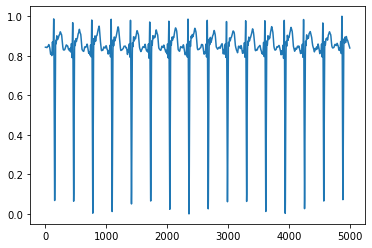

In [12]:
denoised = denoising(df['signal'].iloc[100][6], 500)
plt.plot(denoised)

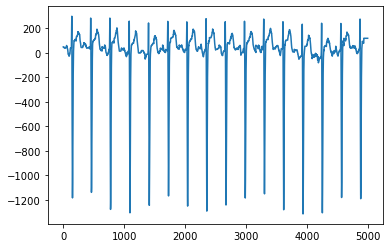

In [13]:
plt.plot(df['signal'].iloc[100][6])

In [14]:
def peak_detection(data, sampling_rate1):
    peaks =  biosppy.signals.ecg.christov_segmenter(signal=data, sampling_rate = sampling_rate1)[0]
    return peaks    

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

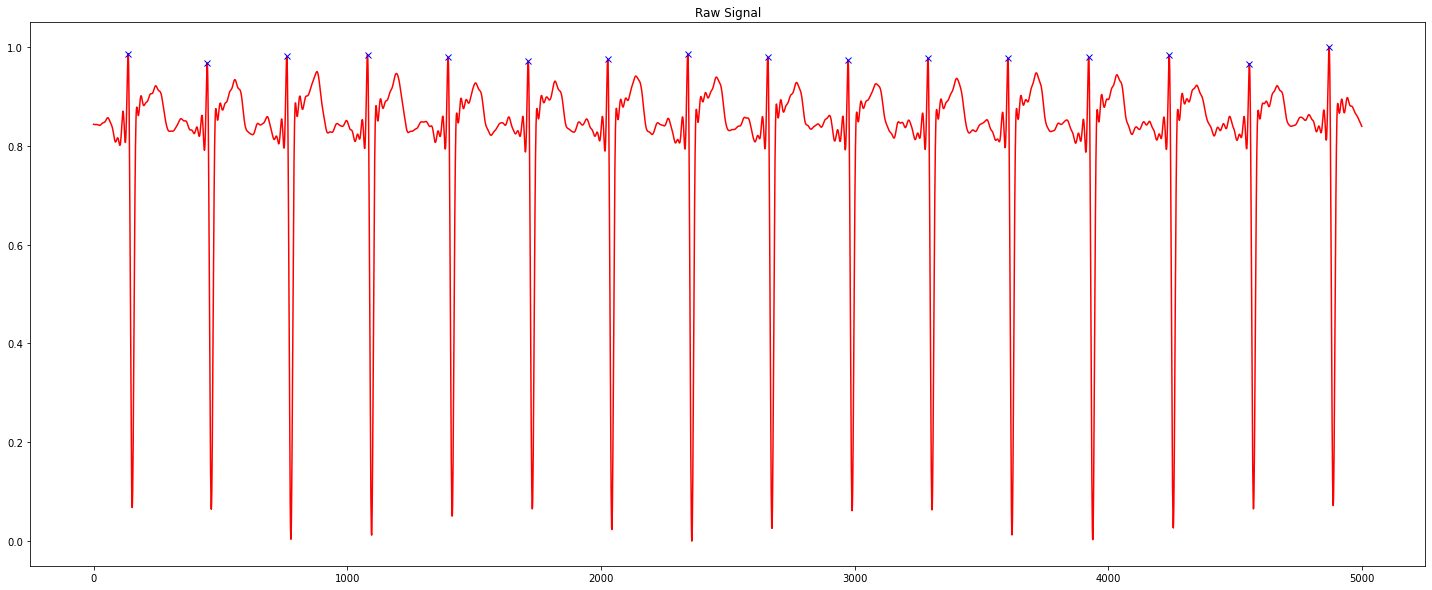

In [15]:
a = denoised
a = (a - a.min())/(a.max() - a.min())
p = peak_detection(a, 500)

fig = plt.figure(figsize=(25, 10))
fig.clear()

fig.add_subplot(111, title="Raw Signal")
plt.plot(a, color='red')
plt.plot(p, a[p], 'x', color='blue')
plt.figure

In [16]:
from scipy.stats import kurtosis, skew
print(kurtosis(a))
print(skew(a))

14.00238073161134
-3.7158818596037424


In [17]:
peaks, info = nk.ecg_peaks(a, sampling_rate=500)

In [18]:
info


{'ECG_R_Peaks': array([ 448,  761, 1080, 1397, 1713, 2027, 2342, 2658, 2974, 3289, 3604,
        3922, 4240, 4556, 4870]),
 'sampling_rate': 500}

In [19]:
p

array([ 136,  448,  761, 1080, 1397, 1713, 2027, 2342, 2658, 2974, 3289,
       3604, 3922, 4240, 4556, 4870])

In [20]:
hrv_non = nk.hrv_time(peaks, sampling_rate=500)
hrv_non

,HRV_RMSSD,HRV_MeanNN,HRV_SDNN,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_pNN50,HRV_pNN20,HRV_TINN,HRV_HTI
0,4.472136,631.714286,3.406523,4.651992,0.005393,0.007079,632.0,2.9652,0.004692,3.5,0.0,0.0,12.0,3.5


In [21]:
hrv_non.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDSD', 'HRV_CVNN',
       'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN',
       'HRV_pNN50', 'HRV_pNN20', 'HRV_TINN', 'HRV_HTI'],
      dtype='object')

In [22]:
p

array([ 136,  448,  761, 1080, 1397, 1713, 2027, 2342, 2658, 2974, 3289,
       3604, 3922, 4240, 4556, 4870])

In [23]:
def feature_extraction(signal, peaks):
    '''
    Feature Extraction ; pre-RR, post-RR, 
    #nn50  = np.sum(np.abs(np.diff(rr)) > 50)*1
    #rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
    '''
    
    preRR  = np.empty(peaks.shape[0]-2)
    postRR = np.empty(peaks.shape[0]-2)
    
    #HOS features
    hos_1 = skew(signal)
    hos_2 = kurtosis(signal)
    
    #RMSSD

#     hrv_time = nk.hrv_time(peaks, sampling_rate=500)
#     rmssd = hrv_non['HRV_RMSSD'][0]

    for i in range(1,peaks.shape[0]-1):
        preRR[i-1] = peaks[i] - peaks[i-1]
        postRR[i-1] = peaks[i+1] - peaks[i]

    rr = np.diff(peaks)
    avg_RR  = np.average(rr)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr))))
    
    return preRR, postRR, hos_1, hos_2, rmssd, avg_RR

In [24]:
preRR, postRR, hos_1, hos_2, rmssd, avg_RR = feature_extraction(a,p)

In [25]:
def extract_qrs_complex(sig1,peaks, n):
    '''
    extract qrs complex and downsample the signal to n samples
    '''
    temp, rpeaks = biosppy.signals.ecg.extract_heartbeats(signal=sig1, rpeaks=peaks, sampling_rate=500.0, before=0.2, after=0.4)
    new_temp =[]
    for i in range(temp.shape[0]):
        new_temp.append(s.resample(temp[i],n))
    return np.asarray(new_temp), rpeaks

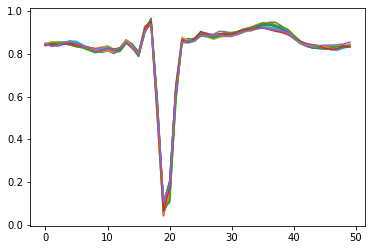

In [26]:
t, rp = extract_qrs_complex(a,p, 50)
for i in range(t.shape[0]):
    plt.plot(t[i])

In [27]:
def dataset_compressed(df):
    '''
    Taking one sample per record; useful for test accuracy
    '''
    
    sampling_freq = 500
    down_sample =50
    lead=6
    columns = ['id','pre-RR', 'post-RR','RMSSD','avg_RR','class', 'signal']
    ecg = pd.DataFrame(columns=columns)
    
    
    for i in range(df.shape[0]):
        print("Sample# : ", df['id'].iloc[i])
        raw_signal = df['signal'].iloc[i][lead]

        #denoising the signal
        signal =denoising(raw_signal, sampling_freq)
        #print("Denoising: ",np.isnan(signal))

        #finding the peaks
        peaks = peak_detection(signal, sampling_freq)
        
        #print("Finding Peaks: ", np.isnan(peaks))

        #extracting each QRS Complex and downsample to 50 samples
        temps, peaks = extract_qrs_complex(signal,peaks, down_sample)
        #print("Extracting QRS Complex: ", np.isnan(temps))
        if peaks.shape[0]<=3:
            continue
        
        #fidning the features
        preRR, postRR, hos_1, hos_2, rmssd, avg_RR = feature_extraction(signal, peaks)
        
        #To make all the arrays of uniform size
        temps = np.delete(temps, [0,temps.shape[0]-1], 0)
        
        print("The shape of Peaks array is: ", peaks.shape)
        print("The shape of Features array is: ", preRR.shape, "and ", postRR.shape)
        print("The shape of Temps arrays is: ", temps.shape)
        #print("Extracting Features: ", np.isnan(preRR),np.isnan(postRR),np.isnan(r_amp),np.isnan(rmssd),np.isnan(nn50))
        
        #if the signal is short
        
        if preRR.shape[0]-1 < 3:
            k=1      
        else:
            k=3
            
        row ={
                'id'     : df['id'].iloc[i],
                'pre-RR' : preRR[k],
                'post-RR'  : postRR[k],
                #'Skew': hos_1,
                #'Kurtosis': hos_2,
                'RMSSD' : rmssd,
                'avg_RR': avg_RR,
                'signal' : temps[k],
                'class' : df['class'].iloc[i]
        }

        ecg = ecg.append(row, ignore_index=True)  
            

    ecg['class'] = [int(x) for x in ecg['class']]
    #ecg['NN50'] = [int(x) for x in ecg['NN50']]
    return ecg

In [28]:
n_samples = 10000 #10000
df_train, df_val, df_test = labels(extract_raw_data(n_samples))
df_train = dataset_compressed(df_train)

The number of ECG records taken for training are:  2713
The number of ECG records taken for validation are:  28
The number of ECG records taken for testing are:  305
Sample# :  HR08927
The shape of Peaks array is:  (11,)
The shape of Features array is:  (9,) and  (9,)
The shape of Temps arrays is:  (9, 50)
Sample# :  HR09535
The shape of Peaks array is:  (9,)
The shape of Features array is:  (7,) and  (7,)
The shape of Temps arrays is:  (7, 50)
Sample# :  HR03143
The shape of Peaks array is:  (11,)
The shape of Features array is:  (9,) and  (9,)
The shape of Temps arrays is:  (9, 50)
Sample# :  HR02677
The shape of Peaks array is:  (12,)
The shape of Features array is:  (10,) and  (10,)
The shape of Temps arrays is:  (10, 50)
Sample# :  HR09986
The shape of Peaks array is:  (14,)
The shape of Features array is:  (12,) and  (12,)
The shape of Temps arrays is:  (12, 50)
Sample# :  HR00465
The shape of Peaks array is:  (18,)
The shape of Features array is:  (16,) and  (16,)
The shape of T

In [29]:
df_val = dataset_compressed(df_val)
print('--------------------------------------------------------')
df_test_comp = df_test.copy()
df_test_comp = dataset_compressed(df_test_comp)
df_test = dataset_compressed(df_test)

Sample# :  HR01052
The shape of Peaks array is:  (17,)
The shape of Features array is:  (15,) and  (15,)
The shape of Temps arrays is:  (15, 50)
Sample# :  HR07665
The shape of Peaks array is:  (12,)
The shape of Features array is:  (10,) and  (10,)
The shape of Temps arrays is:  (10, 50)
Sample# :  HR02200
The shape of Peaks array is:  (13,)
The shape of Features array is:  (11,) and  (11,)
The shape of Temps arrays is:  (11, 50)
Sample# :  HR06343
The shape of Peaks array is:  (9,)
The shape of Features array is:  (7,) and  (7,)
The shape of Temps arrays is:  (7, 50)
Sample# :  HR04438
The shape of Peaks array is:  (8,)
The shape of Features array is:  (6,) and  (6,)
The shape of Temps arrays is:  (6, 50)
Sample# :  HR00532
The shape of Peaks array is:  (11,)
The shape of Features array is:  (9,) and  (9,)
The shape of Temps arrays is:  (9, 50)
Sample# :  HR03938
The shape of Peaks array is:  (9,)
The shape of Features array is:  (7,) and  (7,)
The shape of Temps arrays is:  (7, 50)


In [30]:
print(df_train['class'].mean())
print(df_val['class'].mean())
print(df_test['class'].mean())
print(df_test_comp['class'].mean())

0.5027870680044593
0.5714285714285714
0.46381578947368424
0.46381578947368424


In [31]:
df_train.head(20)

,id,pre-RR,post-RR,RMSSD,avg_RR,class,signal
0,HR08927,461.0,315.0,146.857830,429.300000,1,"[0.6443696910842776, 0.6173219896338045, 0.628..."
1,HR09535,486.0,498.0,8.115241,490.875000,0,"[0.8089132313428145, 0.8090582429492261, 0.816..."
2,HR03143,400.0,420.0,21.351555,416.100000,0,"[0.7127819847063974, 0.6772925368952236, 0.689..."
3,HR02677,411.0,273.0,276.719714,397.090909,0,"[0.8281248054832374, 0.8013300714604342, 0.791..."
4,HR09986,365.0,280.0,85.025976,352.692308,1,"[0.777752416583162, 0.7479875448763562, 0.7557..."
5,HR00465,264.0,263.0,2.031010,265.176471,1,"[0.8910642922794876, 0.8766619594455537, 0.888..."
6,HR02276,359.0,373.0,94.727840,366.250000,1,"[0.7637418294173051, 0.7270007831478922, 0.736..."
7,HR06633,656.0,621.0,32.616458,638.857143,1,"[0.8303985579895953, 0.8351992944417055, 0.835..."
8,HR00103,291.0,291.0,2.097618,286.000000,1,"[0.7091004372445573, 0.7016419643070044, 0.709..."
9,HR00849,294.0,294.0,1.281740,294.866667,1,"[0.7686094061912525, 0.7688738414521092, 0.765..."


In [32]:
print(len(set(df_train['id'].to_list())))

2691


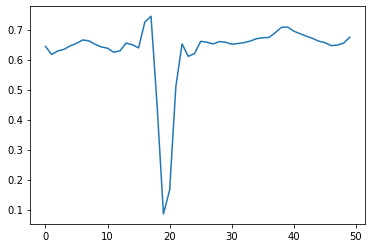

In [33]:
a=df_train.iloc[0]
y= a['signal']
plt.plot(y)

In [34]:
def extract_signal_to_df(ecg):
    columns=[]
    for i in range(50):
        columns.append('sample#'+str(i))
    sg = pd.DataFrame(columns=columns)
    #print(sg.columns)
    for i in range(ecg['signal'].shape[0]):
        #k = [float(x) for x in ecg['signal'][i]]
        k = ecg['signal'][i]
        for j in range(50):
            sg.at[i, 'sample#'+str(j)] = k[j]

#     for i in range(50):
#         ecg['sample#'+str(i)] = pd.to_numeric(ecg['sample#'+str(i)])
    for i in range(50):
        sg['sample#'+str(i)] = sg['sample#'+str(i)].astype(np.float)
    ecg.drop(columns='signal', axis=1, inplace = True)
    ecg = pd.concat([ecg,sg], axis=1)
    
    return ecg
    

In [35]:
df_train = extract_signal_to_df(df_train)

In [36]:
df_val = extract_signal_to_df(df_val)
df_test = extract_signal_to_df(df_test)
df_test_comp = extract_signal_to_df(df_test_comp)


In [37]:
def normalize(df, columns):
    for column in columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())  
    return df
  

In [38]:
# # Normalize the dataset for the svm Model
# columns=['pre-RR', 'post-RR','RMSSD','avg_RR']
# df_train = normalize(df_train, columns)
# df_test = normalize(df_test, columns)
# df_val = normalize(df_val, columns)
# df_test_comp = normalize(df_test_comp, columns)

In [39]:
print("The number of training samples are: ", df_train.shape[0])
print("The number of validation samples are: ", df_val.shape[0])
print("The number of test samples are: ", df_test.shape[0])
print("The number of compressed test samples are: ", df_test_comp.shape[0])

The number of training samples are:  2691
The number of validation samples are:  28
The number of test samples are:  304
The number of compressed test samples are:  304


In [40]:
df_test_comp.head(5)

,id,pre-RR,post-RR,RMSSD,avg_RR,class,sample#0,sample#1,sample#2,sample#3,...,sample#40,sample#41,sample#42,sample#43,sample#44,sample#45,sample#46,sample#47,sample#48,sample#49
0,HR02586,454.0,444.0,79.914538,446.800000,0,0.854898,0.927047,0.909639,0.921427,...,0.941812,0.914424,0.870375,0.799780,0.738608,0.697317,0.702975,0.711500,0.736343,0.739050
1,HR01246,538.0,568.0,27.226563,559.625000,0,0.884336,0.888649,0.877843,0.885527,...,0.978761,0.961256,0.939768,0.908204,0.881183,0.868755,0.865563,0.855247,0.854803,0.859886
2,HR05156,427.0,375.0,62.116825,397.454545,1,0.657141,0.564378,0.562452,0.528304,...,0.626901,0.646036,0.686421,0.738956,0.761280,0.780145,0.771168,0.766276,0.741910,0.766813
3,HR08413,474.0,468.0,5.338539,474.777778,0,0.683336,0.684823,0.690159,0.692914,...,0.740033,0.746984,0.754430,0.752679,0.742140,0.730899,0.719652,0.708492,0.697841,0.691752
4,HR05050,445.0,434.0,11.827463,420.300000,1,0.849322,0.858100,0.860379,0.870213,...,0.885244,0.868688,0.850393,0.840816,0.842103,0.844179,0.844253,0.844959,0.847398,0.845956


In [41]:
df_train.head(5)

,id,pre-RR,post-RR,RMSSD,avg_RR,class,sample#0,sample#1,sample#2,sample#3,...,sample#40,sample#41,sample#42,sample#43,sample#44,sample#45,sample#46,sample#47,sample#48,sample#49
0,HR08927,461.0,315.0,146.857830,429.300000,1,0.644370,0.617322,0.628897,0.634534,...,0.694822,0.686420,0.678324,0.670890,0.661612,0.656687,0.646767,0.648520,0.654988,0.674714
1,HR09535,486.0,498.0,8.115241,490.875000,0,0.808913,0.809058,0.816520,0.821870,...,0.695457,0.701833,0.719621,0.752395,0.787326,0.810340,0.818220,0.821510,0.820770,0.820151
2,HR03143,400.0,420.0,21.351555,416.100000,0,0.712782,0.677293,0.689700,0.724969,...,0.437273,0.478337,0.530152,0.584911,0.649084,0.695603,0.703173,0.699546,0.703179,0.718834
3,HR02677,411.0,273.0,276.719714,397.090909,0,0.828125,0.801330,0.791427,0.802843,...,0.788837,0.784382,0.777772,0.782074,0.785596,0.792020,0.793927,0.797631,0.787095,0.825050
4,HR09986,365.0,280.0,85.025976,352.692308,1,0.777752,0.747988,0.755710,0.784956,...,0.838377,0.803143,0.791536,0.803901,0.783960,0.744054,0.737223,0.756410,0.766983,0.776747


In [42]:
df_test.head(5)

,id,pre-RR,post-RR,RMSSD,avg_RR,class,sample#0,sample#1,sample#2,sample#3,...,sample#40,sample#41,sample#42,sample#43,sample#44,sample#45,sample#46,sample#47,sample#48,sample#49
0,HR02586,454.0,444.0,79.914538,446.800000,0,0.854898,0.927047,0.909639,0.921427,...,0.941812,0.914424,0.870375,0.799780,0.738608,0.697317,0.702975,0.711500,0.736343,0.739050
1,HR01246,538.0,568.0,27.226563,559.625000,0,0.884336,0.888649,0.877843,0.885527,...,0.978761,0.961256,0.939768,0.908204,0.881183,0.868755,0.865563,0.855247,0.854803,0.859886
2,HR05156,427.0,375.0,62.116825,397.454545,1,0.657141,0.564378,0.562452,0.528304,...,0.626901,0.646036,0.686421,0.738956,0.761280,0.780145,0.771168,0.766276,0.741910,0.766813
3,HR08413,474.0,468.0,5.338539,474.777778,0,0.683336,0.684823,0.690159,0.692914,...,0.740033,0.746984,0.754430,0.752679,0.742140,0.730899,0.719652,0.708492,0.697841,0.691752
4,HR05050,445.0,434.0,11.827463,420.300000,1,0.849322,0.858100,0.860379,0.870213,...,0.885244,0.868688,0.850393,0.840816,0.842103,0.844179,0.844253,0.844959,0.847398,0.845956


In [43]:
df_train.describe()

,pre-RR,post-RR,RMSSD,avg_RR,class,sample#0,sample#1,sample#2,sample#3,sample#4,...,sample#40,sample#41,sample#42,sample#43,sample#44,sample#45,sample#46,sample#47,sample#48,sample#49
count,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,...,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000
mean,410.894835,408.270160,62.587630,411.344670,0.502787,0.732519,0.742303,0.741077,0.741909,0.742349,...,0.738299,0.734273,0.731896,0.730472,0.730569,0.728966,0.729205,0.728095,0.727503,0.722254
std,131.105754,127.321273,93.369742,112.390152,0.500085,0.149559,0.157423,0.155773,0.157930,0.159254,...,0.174765,0.170752,0.166933,0.159857,0.155438,0.152975,0.153229,0.151949,0.154410,0.162761
min,17.000000,73.000000,0.707107,168.962963,0.000000,0.066580,0.033661,0.040476,0.005090,0.066801,...,0.025387,0.035454,-0.001080,0.022915,0.034699,0.033955,0.007041,0.007577,0.040756,-0.047286
25%,320.000000,321.000000,8.241878,334.278846,0.000000,0.685973,0.695598,0.692630,0.693911,0.691553,...,0.667872,0.664165,0.664193,0.666443,0.671582,0.676001,0.680968,0.678032,0.679315,0.677996
50%,405.000000,403.000000,27.212130,407.900000,1.000000,0.775122,0.784753,0.784752,0.786620,0.787868,...,0.780673,0.774524,0.772501,0.770747,0.770981,0.769929,0.769508,0.768546,0.769907,0.767716
75%,479.000000,474.500000,86.357639,472.333333,1.000000,0.831558,0.845177,0.842629,0.845257,0.847617,...,0.857558,0.850862,0.844047,0.839179,0.832574,0.828233,0.828119,0.827302,0.827550,0.826576
max,2058.000000,1800.000000,1521.822920,1203.333333,1.000000,0.944609,1.065863,0.994476,1.002727,0.977174,...,0.999446,0.997698,1.001597,1.001797,1.002248,0.993040,0.998748,1.002718,0.994710,1.026675


In [44]:
df_test.describe()

,pre-RR,post-RR,RMSSD,avg_RR,class,sample#0,sample#1,sample#2,sample#3,sample#4,...,sample#40,sample#41,sample#42,sample#43,sample#44,sample#45,sample#46,sample#47,sample#48,sample#49
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,...,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,418.144737,423.631579,63.778684,424.067377,0.463816,0.734581,0.740727,0.743257,0.745306,0.744944,...,0.741838,0.741109,0.740302,0.737198,0.733832,0.730111,0.727373,0.725094,0.726219,0.727724
std,122.044325,131.165236,99.431161,111.293627,0.499511,0.142064,0.155585,0.151278,0.152618,0.153226,...,0.179186,0.168537,0.156920,0.154035,0.153299,0.150521,0.152045,0.149137,0.149448,0.148270
min,103.000000,116.000000,0.760886,173.384615,0.000000,0.115808,0.069045,0.096526,0.100032,0.105611,...,0.050560,0.092278,0.138712,0.162086,0.100247,0.057828,0.017017,0.119823,0.018642,0.005603
25%,334.000000,333.500000,8.464130,336.403846,0.000000,0.682722,0.692126,0.690080,0.692044,0.688930,...,0.680134,0.673015,0.668123,0.668620,0.666351,0.669448,0.677123,0.673039,0.675209,0.672402
50%,419.000000,417.000000,25.178846,424.150000,0.000000,0.775262,0.778337,0.780133,0.784984,0.784445,...,0.787947,0.783584,0.779035,0.776077,0.772151,0.764502,0.765053,0.758917,0.765559,0.768996
75%,486.250000,491.250000,79.992641,495.625000,1.000000,0.832380,0.848552,0.850596,0.851801,0.848353,...,0.857612,0.852725,0.849760,0.842300,0.839798,0.834207,0.833038,0.827221,0.832621,0.828183
max,857.000000,1097.000000,882.271075,858.400000,1.000000,0.939245,0.965742,0.960136,0.955824,0.967315,...,0.997752,0.998534,0.991689,0.983791,0.999111,0.989374,0.980636,0.983961,0.947732,0.935432


In [45]:
df_val.head(5)

,id,pre-RR,post-RR,RMSSD,avg_RR,class,sample#0,sample#1,sample#2,sample#3,...,sample#40,sample#41,sample#42,sample#43,sample#44,sample#45,sample#46,sample#47,sample#48,sample#49
0,HR01052,243.0,216.0,61.732217,284.312500,1,0.777789,0.785407,0.759002,0.749983,...,0.787800,0.764128,0.760483,0.752318,0.739619,0.737289,0.742524,0.719349,0.734860,0.761613
1,HR07665,530.0,278.0,106.964013,362.454545,1,0.873701,0.867746,0.861997,0.870052,...,0.954673,0.918898,0.878999,0.866124,0.874013,0.872936,0.862336,0.857990,0.867903,0.873602
2,HR02200,320.0,242.0,151.126678,362.000000,1,0.860085,0.942422,0.991899,0.941911,...,0.831480,0.859830,0.900799,0.950870,0.973771,0.930090,0.847031,0.787482,0.782170,0.807858
3,HR06343,522.0,508.0,17.647339,514.125000,0,0.213567,0.168678,0.174118,0.161705,...,0.141949,0.172068,0.199880,0.223707,0.237277,0.255093,0.256608,0.258327,0.252825,0.269730
4,HR04438,574.0,576.0,10.344080,576.285714,0,0.852619,0.868879,0.873036,0.892665,...,0.897586,0.894714,0.887118,0.871253,0.859214,0.847269,0.837938,0.826574,0.827653,0.824950


In [46]:
df_train.describe()

,pre-RR,post-RR,RMSSD,avg_RR,class,sample#0,sample#1,sample#2,sample#3,sample#4,...,sample#40,sample#41,sample#42,sample#43,sample#44,sample#45,sample#46,sample#47,sample#48,sample#49
count,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,...,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000
mean,410.894835,408.270160,62.587630,411.344670,0.502787,0.732519,0.742303,0.741077,0.741909,0.742349,...,0.738299,0.734273,0.731896,0.730472,0.730569,0.728966,0.729205,0.728095,0.727503,0.722254
std,131.105754,127.321273,93.369742,112.390152,0.500085,0.149559,0.157423,0.155773,0.157930,0.159254,...,0.174765,0.170752,0.166933,0.159857,0.155438,0.152975,0.153229,0.151949,0.154410,0.162761
min,17.000000,73.000000,0.707107,168.962963,0.000000,0.066580,0.033661,0.040476,0.005090,0.066801,...,0.025387,0.035454,-0.001080,0.022915,0.034699,0.033955,0.007041,0.007577,0.040756,-0.047286
25%,320.000000,321.000000,8.241878,334.278846,0.000000,0.685973,0.695598,0.692630,0.693911,0.691553,...,0.667872,0.664165,0.664193,0.666443,0.671582,0.676001,0.680968,0.678032,0.679315,0.677996
50%,405.000000,403.000000,27.212130,407.900000,1.000000,0.775122,0.784753,0.784752,0.786620,0.787868,...,0.780673,0.774524,0.772501,0.770747,0.770981,0.769929,0.769508,0.768546,0.769907,0.767716
75%,479.000000,474.500000,86.357639,472.333333,1.000000,0.831558,0.845177,0.842629,0.845257,0.847617,...,0.857558,0.850862,0.844047,0.839179,0.832574,0.828233,0.828119,0.827302,0.827550,0.826576
max,2058.000000,1800.000000,1521.822920,1203.333333,1.000000,0.944609,1.065863,0.994476,1.002727,0.977174,...,0.999446,0.997698,1.001597,1.001797,1.002248,0.993040,0.998748,1.002718,0.994710,1.026675


In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2691 entries, 0 to 2690
Data columns (total 56 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2691 non-null   object 
 1   pre-RR     2691 non-null   float64
 2   post-RR    2691 non-null   float64
 3   RMSSD      2691 non-null   float64
 4   avg_RR     2691 non-null   float64
 5   class      2691 non-null   int64  
 6   sample#0   2691 non-null   float64
 7   sample#1   2691 non-null   float64
 8   sample#2   2691 non-null   float64
 9   sample#3   2691 non-null   float64
 10  sample#4   2691 non-null   float64
 11  sample#5   2691 non-null   float64
 12  sample#6   2691 non-null   float64
 13  sample#7   2691 non-null   float64
 14  sample#8   2691 non-null   float64
 15  sample#9   2691 non-null   float64
 16  sample#10  2691 non-null   float64
 17  sample#11  2691 non-null   float64
 18  sample#12  2691 non-null   float64
 19  sample#13  2691 non-null   float64
 20  sample#1

In [48]:
# df_train.to_csv('train.csv')
# df_test.to_csv('test.csv')
# df_val.to_csv('val.csv')
# df_test_comp.to_csv('test_comp.csv')


# **Models**

In [49]:
X_train = df_train.drop(['class', 'id'], axis=1)
y_train = df_train['class']

X_test = df_test.drop(['class', 'id'], axis=1)
y_test = df_test['class']

X_val = df_val.drop(['class', 'id'], axis=1)
y_val = df_val['class']


In [50]:
print("The number of training samples are: ", X_train.shape, y_train.shape) 

print("The number of testing samples are: ", X_test.shape, y_test.shape) 

print("The number of validation samples are: ", X_val.shape, y_val.shape) 


The number of training samples are:  (2691, 54) (2691,)
The number of testing samples are:  (304, 54) (304,)
The number of validation samples are:  (28, 54) (28,)


**SVM**

In [51]:
from sklearn import svm

In [52]:
svc = svm.SVC(kernel='rbf',random_state=42)
svc.fit(X_train, y_train)

SVC(random_state=42)

In [53]:
y_pred = svc.predict(X_test)

Test Accuracy: 0.805921052631579
The Classification report : 
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       163
           1       0.81      0.76      0.78       141

    accuracy                           0.81       304
   macro avg       0.81      0.80      0.80       304
weighted avg       0.81      0.81      0.81       304

The ROC AUC Score is: 
0.8027455075490579


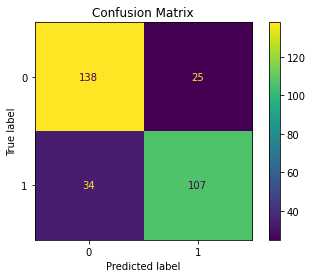

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

print("Test Accuracy:",accuracy_score(y_test, y_pred))

print("The Classification report : ")
print(classification_report(y_test, y_pred))

print("The ROC AUC Score is: ")
print(roc_auc_score(y_test, y_pred))

plot_confusion_matrix(svc, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

In [55]:
y_pred_train = svc.predict(X_train)
print("Train Accuracy:",accuracy_score(y_train, y_pred_train))


Train Accuracy: 0.7959866220735786


**Random Forests**

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rfc = RandomForestClassifier(random_state=42)

In [58]:
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [59]:
y_pred = rfc.predict(X_test)

Test Accuracy: 0.7861842105263158
The Classification report : 
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       163
           1       0.75      0.80      0.78       141

    accuracy                           0.79       304
   macro avg       0.79      0.79      0.79       304
weighted avg       0.79      0.79      0.79       304

The ROC AUC Score is: 
0.7872122873428186


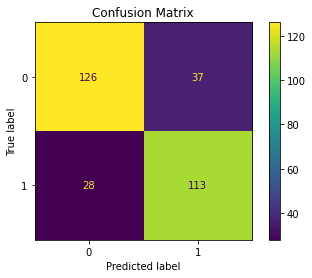

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

print("Test Accuracy:",accuracy_score(y_test, y_pred))

print("The Classification report : ")
print(classification_report(y_test, y_pred))

print("The ROC AUC Score is: ")
print(roc_auc_score(y_test, y_pred))

plot_confusion_matrix(rfc, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

In [61]:
y_pred_train = rfc.predict(X_train)
print("Train Accuracy:",accuracy_score(y_train, y_pred_train))


Train Accuracy: 1.0


**XGBoost**

In [62]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

Test Accuracy: 0.7828947368421053
The Classification report : 
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       163
           1       0.76      0.77      0.77       141

    accuracy                           0.78       304
   macro avg       0.78      0.78      0.78       304
weighted avg       0.78      0.78      0.78       304

The ROC AUC Score is: 
0.7822303441674281


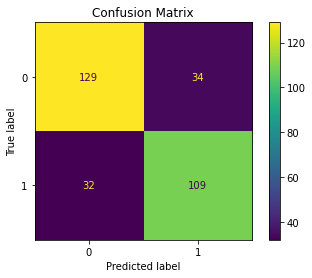

In [63]:
print("Test Accuracy:",accuracy_score(y_test, y_pred))

print("The Classification report : ")
print(classification_report(y_test, y_pred))

print("The ROC AUC Score is: ")
print(roc_auc_score(y_test, y_pred))

plot_confusion_matrix(xgb, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

In [64]:
y_pred_train = xgb.predict(X_train)
print("Train Accuracy:",accuracy_score(y_train, y_pred_train))

Train Accuracy: 1.0


**LightGBM**

In [65]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state= 42)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

Test Accuracy: 0.7730263157894737
The Classification report : 
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       163
           1       0.75      0.77      0.76       141

    accuracy                           0.77       304
   macro avg       0.77      0.77      0.77       304
weighted avg       0.77      0.77      0.77       304

The ROC AUC Score is: 
0.7725492755514946


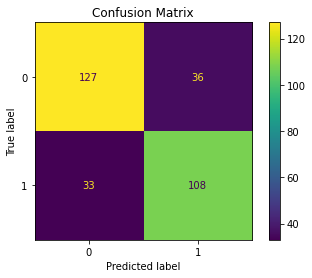

In [66]:
print("Test Accuracy:",accuracy_score(y_test, y_pred))

print("The Classification report : ")
print(classification_report(y_test, y_pred))

print("The ROC AUC Score is: ")
print(roc_auc_score(y_test, y_pred))

plot_confusion_matrix(lgbm, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

In [67]:
y_pred_train = lgbm.predict(X_train)
print("Train Accuracy:",accuracy_score(y_train, y_pred_train))

Train Accuracy: 0.9973987365291713


**Neural Network**

In [68]:
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import *
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.autograd import Variable

In [69]:
# prepare the dataset
def prepare_data(train, val, test):
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    val_dl = DataLoader(val, batch_size=1024, shuffle=False)
    return train_dl, val_dl,test_dl

In [70]:
X_train.shape

(2691, 54)

In [71]:
# converting training data into torch format
train_x = np.array(X_train)
train_x = train_x.reshape(X_train.shape[0], X_train.shape[1])
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = np.array(y_train.astype(int))
train_y = train_y.reshape(train_y.shape[0], 1)
train_y = torch.from_numpy(train_y)

# shape of training data
print("The training size is:",train_x.shape, train_y.shape)
print('--------------------------------------------------')

# converting testing data into torch format
test_x = np.array(X_test)
test_x = test_x.reshape(X_test.shape[0], X_test.shape[1])
test_x  = torch.from_numpy(test_x)

# converting the target into torch format
test_y = np.array(y_test.astype(int))
test_y = test_y.reshape(test_y.shape[0], 1)
test_y = torch.from_numpy(test_y)

# shape of training data
print("The testing size is:",test_x.shape, test_y.shape)
print('--------------------------------------------------')

# converting val data into torch format
val_x = np.array(X_val)
val_x = val_x.reshape(X_val.shape[0], X_val.shape[1])
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = np.array(y_val.astype(int))
val_y = val_y.reshape(val_y.shape[0], 1)
val_y = torch.from_numpy(val_y)

# shape of training data
print("The validation size is:",val_x.shape, val_y.shape)
print('--------------------------------------------------')




The training size is: torch.Size([2691, 54]) torch.Size([2691, 1])
--------------------------------------------------
The testing size is: torch.Size([304, 54]) torch.Size([304, 1])
--------------------------------------------------
The validation size is: torch.Size([28, 54]) torch.Size([28, 1])
--------------------------------------------------


In [72]:
#Defining the model

class ann(Module):
    def __init__(self, n_inputs):
        super(ann, self).__init__()
        
        self.hidden0 = Linear(n_inputs, 5)
        kaiming_uniform_(self.hidden0.weight, nonlinearity='relu')
        self.act0 = ReLU()
        
        #first input layer
        self.hidden1 = Linear(5, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        
        #second input layer
        self.hidden2 = Linear(10, 30)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        
        #third input Layer
        self.hidden3 = Linear(30, 30)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        
        #fourth input Layer
        self.hidden4 = Linear(30, 10)
        kaiming_uniform_(self.hidden4.weight, nonlinearity='relu')
        self.act4 = ReLU()
        
        self.hidden41 = Linear(10, 5)
        kaiming_uniform_(self.hidden41.weight, nonlinearity='relu')
        self.act41 = ReLU()
        
        #output Layer
        self.hidden5 = Linear(5,1)
        xavier_uniform_(self.hidden5.weight)
        self.act5 = Sigmoid()
    
    #Forward Propagation
    def forward(self, X):
        X = self.hidden0(X)
        X = self.act0(X)
        
        X = self.hidden1(X)
        X = self.act1(X)
        
        X = self.hidden2(X)
        X = self.act2(X)
        
        X = self.hidden3(X)
        X = self.act3(X)
    
        X = self.hidden4(X)
        X = self.act4(X)
        
        X = self.hidden41(X)
        X = self.act41(X)
        
        X = self.hidden5(X)
        X = self.act5(X)
        
        return X      

In [85]:
n_epochs = 50
lr = 0.01
n_inputs = train_x.shape[1]
print(n_inputs)

54


In [86]:
# defining the model
model = ann(n_inputs)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=lr)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ann(
  (hidden0): Linear(in_features=54, out_features=5, bias=True)
  (act0): ReLU()
  (hidden1): Linear(in_features=5, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=30, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=30, out_features=30, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=30, out_features=10, bias=True)
  (act4): ReLU()
  (hidden41): Linear(in_features=10, out_features=5, bias=True)
  (act41): ReLU()
  (hidden5): Linear(in_features=5, out_features=1, bias=True)
  (act5): Sigmoid()
)


In [87]:
def train(n_epochs):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train.float())
    output_val = model(x_val.float())

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.float())
    loss_val = criterion(output_val, y_val.float())
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [88]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  2 	 loss : tensor(1.1583, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  3 	 loss : tensor(0.6465, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  4 	 loss : tensor(0.6431, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  5 	 loss : tensor(0.5161, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  6 	 loss : tensor(0.6588, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  7 	 loss : tensor(0.6123, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  8 	 loss : tensor(0.6383, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  9 	 loss : tensor(0.6578, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  10 	 loss : tensor(0.5262, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  11 	 loss : tensor(0.5224, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  12 	 loss : tensor(0.5584, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  13 	 loss : tensor(0.6276, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  14 	 loss : tensor(0.6781, grad_fn=<BinaryCrossEntropyBackward>)
Epoch :  15 	 loss : tensor(0.6644, grad_fn=<B

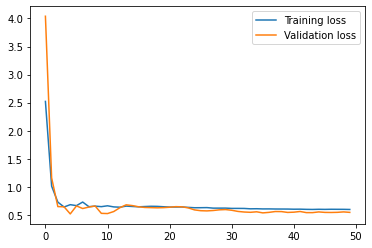

In [89]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

0.7112597547380156
0.7119902956061767
The Classification report : 
              precision    recall  f1-score   support

           0       0.67      0.84      0.74      1338
           1       0.79      0.58      0.67      1353

    accuracy                           0.71      2691
   macro avg       0.73      0.71      0.71      2691
weighted avg       0.73      0.71      0.71      2691



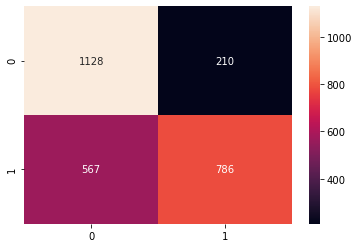

In [90]:
import seaborn as sns
# prediction for training set
with torch.no_grad():
    output = model(train_x.float())

a = list(output.numpy().squeeze())
a = [0 if a_<0.5 else 1 for a_ in a]
    

predictions = a

# accuracy on training set
print(accuracy_score(train_y, predictions))
print(roc_auc_score(train_y, predictions))
print("The Classification report : ")
print(classification_report(train_y, predictions))
conf = confusion_matrix(train_y, predictions)
sns.heatmap(conf, fmt='d',annot=True)
plt.show()

0.75
0.78125
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       1.00      0.56      0.72        16

    accuracy                           0.75        28
   macro avg       0.82      0.78      0.75        28
weighted avg       0.84      0.75      0.74        28



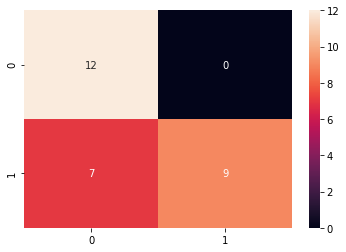

In [91]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.float())

a = list(output.numpy().squeeze())
a = [0 if a_<0.55 else 1 for a_ in a]
predictions = a

# accuracy on validation set
accuracy_score(val_y, predictions)
print(accuracy_score(val_y, predictions))
print(roc_auc_score(val_y, predictions))
print(classification_report(val_y, predictions))
conf = confusion_matrix(val_y, predictions)
sns.heatmap(conf, fmt='d',annot=True)
plt.show()

0.7203947368421053
0.7115041552451813
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       163
           1       0.75      0.59      0.66       141

    accuracy                           0.72       304
   macro avg       0.73      0.71      0.71       304
weighted avg       0.73      0.72      0.72       304



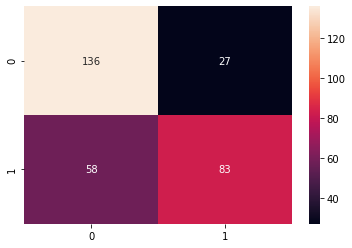

In [92]:
# generating predictions for test set
with torch.no_grad():
    output = model(test_x.float())

a = list(output.numpy().squeeze())
a = [0 if a_<0.55 else 1 for a_ in a]
predictions = a

accuracy_score(test_y, predictions)
print(accuracy_score(test_y, predictions))
print(roc_auc_score(test_y, predictions))
print(classification_report(test_y, predictions))
conf = confusion_matrix(test_y, predictions)
sns.heatmap(conf, fmt='d',annot=True)
plt.show()